In [1]:
# Project 2 of MATH6380O, Spring 2018
# 
# Image Captioning
# NG, Ka Chung (SID: 20097188) and LO, Yi-Su (SID: 20399988). 
# Each person contributes a half of the work, including programming, experiments, and discussion.
#
# Contact: yloab@ust.hk

In [99]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd

import tensorflow as tf

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Merge, Activation, Flatten
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image

from keras.backend.tensorflow_backend import set_session

import nltk

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
set_session(tf.Session(config=config))

In [100]:
from tensorflow.python.client import device_lib

In [101]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10468741963680712941
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11596411699
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1127187345500725536
physical_device_desc: "device: 0, name: TITAN Xp, pci bus id: 0000:03:00.0, compute capability: 6.1"
]


In [102]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

# Dataset

In [5]:
token = 'Flickr8k_text/Flickr8k.token.txt'

In [6]:
captions = open(token, 'r').read().strip().split('\n')

In [7]:
# Creating a dictionary containing all the captions of the images

d = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]

In [8]:
d['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [9]:
images_pth = 'Flicker8k_Dataset/'

In [10]:
# Contains all the images
img = glob.glob(images_pth+'*.jpg')

In [11]:
img[:5]

['Flicker8k_Dataset\\1000268201_693b08cb0e.jpg',
 'Flicker8k_Dataset\\1001773457_577c3a7d70.jpg',
 'Flicker8k_Dataset\\1002674143_1b742ab4b8.jpg',
 'Flicker8k_Dataset\\1003163366_44323f5815.jpg',
 'Flicker8k_Dataset\\1007129816_e794419615.jpg']

In [12]:
train_images_file = 'Flickr8k_text/Flickr_8k.trainImages.txt'

In [13]:
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

In [14]:
def split_data(l):
    temp = []
    for i in img:
        if i[len(images_pth):] in l:
            temp.append(i)
    return temp

In [15]:
# Getting the training images from all the images

train_img = split_data(train_images)
len(train_img)

6000

In [16]:
val_images_file = 'Flickr8k_text/Flickr_8k.devImages.txt'
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))

In [17]:
# Getting the validation images from all the images
val_img = split_data(val_images)
len(val_img)

1000

In [18]:
test_images_file = 'Flickr8k_text/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

In [19]:
# Getting the testing images from all the images
test_img = split_data(test_images)
len(test_img)

1000

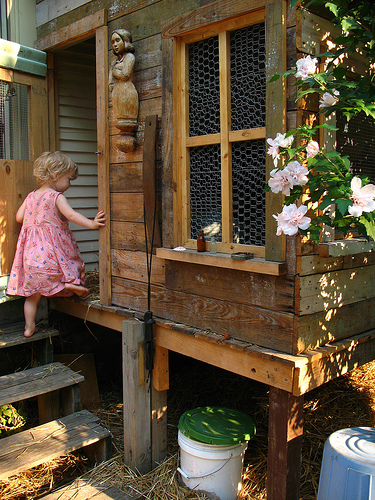

In [20]:
Image.open(train_img[0])

# Image Encoding

In [21]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [22]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    #img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    x = preprocess_input(x)
    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


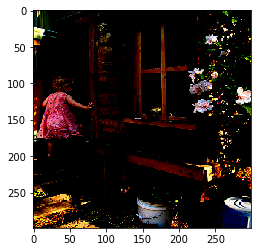

In [244]:
plt.imshow(np.squeeze(preprocess(train_img[0])))

In [24]:
model = InceptionV3(weights='imagenet')

In [25]:
from keras.models import Model

new_input = model.input
hidden_layer = model.layers[-2].output

model_new = Model(new_input, hidden_layer)

In [26]:
def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

CNN encoding for training data

In [27]:
encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img[len(images_pth):]] = encode(img)

100%|██████████████████████████████████████████████████████████████████████████████| 6000/6000 [06:09<00:00, 16.23it/s]


In [28]:
with open("encoded_images_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle) 

In [29]:
encoding_train = pickle.load(open('encoded_images_inceptionV3.p', 'rb'))

In [30]:
encoding_train['3556792157_d09d42bef7.jpg'].shape

(2048,)

CNN encoding for testing data

In [31]:
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images_pth):]] = encode(img)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:00<00:00, 16.48it/s]


In [32]:
with open("encoded_images_test_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle) 

In [33]:
encoding_test = pickle.load(open('encoded_images_test_inceptionV3.p', 'rb'))

In [34]:
encoding_test[test_img[0][len(images_pth):]].shape

(2048,)

Create dictionaries for training, validation and testing data

In [35]:
train_d = {}
for i in train_img:
    if i[len(images_pth):] in d:
        train_d[i] = d[i[len(images_pth):]]

In [36]:
len(train_d)

6000

In [37]:
train_d['Flicker8k_Dataset\\316833109_6500b526dc.jpg']

['A brown dog carries a multiple colored toy in the grass .',
 'A brown dog is running across the yard with its toy in its mouth .',
 'A dog with a toy runs through the grass .',
 'A golden retriever runs through grass carrying a dog toy .',
 'The dog is running with his toy in his mouth .']

In [38]:
val_d = {}
for i in val_img:
    if i[len(images_pth):] in d:
        val_d[i] = d[i[len(images_pth):]]

In [39]:
len(val_d)

1000

In [40]:
test_d = {}
for i in test_img:
    if i[len(images_pth):] in d:
        test_d[i] = d[i[len(images_pth):]]

In [41]:
len(test_d)

1000

Calculating the unique words in the vocabulary

In [42]:
caps = []
for key, val in train_d.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')

In [43]:
words = [i.split() for i in caps]

In [44]:
unique = []
for i in words:
    unique.extend(i)

In [45]:
unique = list(set(unique))

In [46]:
unique = pickle.load(open('unique.p', 'rb'))
len(unique)

8256

In [47]:
word2idx = {val:index for index, val in enumerate(unique)}

Mapping the unique words to indices and vice-versa

In [48]:
word2idx['<start>']

5553

In [49]:
idx2word = {index:val for index, val in enumerate(unique)}

In [50]:
idx2word[5553]

'<start>'

In [51]:
max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)
max_len

40

In [52]:
vocab_size = len(unique)
vocab_size

8256

Calculating the maximum length among all the captions

In [53]:
f = open('flickr8k_training_dataset.txt', 'w')
f.write("image_id\tcaptions\n")

18

In [54]:
for key, val in train_d.items():
    for i in val:
        f.write(key[len(images_pth):] + "\t" + "<start> " + i +" <end>" + "\n")

f.close()

In [55]:
df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')

Adding <start> and <end> to all the captions to indicate the starting and ending of a sentence. This will be used while we predict the caption of an image

In [56]:
len(df)

30000

In [57]:
c = [i for i in df['captions']]
len(c)

30000

In [58]:
imgs = [i for i in df['image_id']]

In [59]:
a = c[-1]
a, imgs[-1]

('<start> Woman writing on a pad in room with gold , decorated walls . <end>',
 '997338199_7343367d7f.jpg')

In [60]:
for i in a.split():
    print (i, "=>", word2idx[i])

<start> => 5553
Woman => 860
writing => 3643
on => 803
a => 32
pad => 6042
in => 8156
room => 7022
with => 4350
gold => 8122
, => 5672
decorated => 4539
walls => 7915
. => 7023
<end> => 5232


In [61]:
# Totel samples = sum of no. of words in each caption 

samples_per_epoch = 0
for ca in caps:
    samples_per_epoch += len(ca.split())-1

In [62]:
samples_per_epoch

383454

## Generator

In [63]:
def data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []
        
        df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_train[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(vocab_size)
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0

# Word2Vec

In [64]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('word2vec/GoogleNews-vectors-negative300.bin', binary=True)

EMBEDDING_DIM=300
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for i, word in enumerate(unique):
    #if i>=NUM_WORDS:
    #    continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word_vectors)

C:\Users\kcngae\AppData\Local\conda\conda\envs\tensorflow-gpu-boris\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Model Development

In [122]:
image_model = Sequential([
        Dense(EMBEDDING_DIM, input_shape=(2048,), activation='relu'),
        RepeatVector(max_len)
    ])

Since we are going to predict the next word using the previous words(length of previous words changes with every iteration over the caption), we have to set return_sequences = True.

Besides, we use Google's pre-trained Word2Vec for the word embedding layer. The weights are fixed.

In [123]:
caption_model = Sequential([
        Embedding(vocab_size, EMBEDDING_DIM, input_length=max_len, weights=[embedding_matrix], trainable=False),
        LSTM(256, return_sequences=True),
        TimeDistributed(Dense(300))
    ])

Merging the models and creating a softmax classifier

In [124]:
final_model = Sequential([
        Merge([image_model, caption_model], mode='concat', concat_axis=1),
        Bidirectional(LSTM(256, return_sequences=False)),
        Dense(vocab_size),
        Activation('softmax')
    ])

C:\Users\kcngae\AppData\Local\conda\conda\envs\tensorflow-gpu-boris\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  


In [125]:
final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [126]:
final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_4 (Merge)              (None, 80, 300)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 512)               1140736   
_________________________________________________________________
dense_12 (Dense)             (None, 8256)              4235328   
_________________________________________________________________
activation_98 (Activation)   (None, 8256)              0         
Total params: 9,115,032
Trainable params: 6,638,232
Non-trainable params: 2,476,800
_________________________________________________________________


In [127]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()_model.fit_generator(data_generator(batch_size), steps_per_epoch=samples_per_epoch // batch_size, 
                          epochs=nb_epoch, verbose=1, callbacks=[time_callback])

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
        
batch_size = 128

In [128]:
nb_epoch = 5

time_callback = TimeHistory()
final_model.fit_generator(data_generator(batch_size), steps_per_epoch=samples_per_epoch // batch_size, 
                          epochs=nb_epoch, verbose=1, callbacks=[time_callback])
times = time_callback.times

Epoch 1/5
 202/2995 [=>............................] - ETA: 10:47:21 - loss: 9.0350 - acc: 0.0000e+0 - ETA: 5:42:07 - loss: 8.7917 - acc: 0.0352    - ETA: 4:00:15 - loss: 8.3449 - acc: 0.04 - ETA: 3:09:09 - loss: 7.9393 - acc: 0.05 - ETA: 2:38:25 - loss: 7.5325 - acc: 0.05 - ETA: 2:17:52 - loss: 7.2787 - acc: 0.05 - ETA: 2:03:17 - loss: 7.0159 - acc: 0.06 - ETA: 1:52:35 - loss: 6.8714 - acc: 0.06 - ETA: 1:44:00 - loss: 6.7664 - acc: 0.06 - ETA: 1:37:11 - loss: 6.6650 - acc: 0.06 - ETA: 1:31:51 - loss: 6.6470 - acc: 0.06 - ETA: 1:27:33 - loss: 6.5661 - acc: 0.07 - ETA: 1:23:42 - loss: 6.5192 - acc: 0.06 - ETA: 1:20:23 - loss: 6.4496 - acc: 0.06 - ETA: 1:17:27 - loss: 6.4109 - acc: 0.06 - ETA: 1:14:50 - loss: 6.3713 - acc: 0.06 - ETA: 1:12:43 - loss: 6.3368 - acc: 0.06 - ETA: 1:10:36 - loss: 6.3161 - acc: 0.06 - ETA: 1:08:45 - loss: 6.2653 - acc: 0.07 - ETA: 1:07:14 - loss: 6.2308 - acc: 0.07 - ETA: 1:05:43 - loss: 6.2238 - acc: 0.07 - ETA: 1:04:23 - loss: 6.1879 - acc: 0.07 - ETA: 1:03:

In [130]:
final_model.save_weights('ImageC_1-5')

In [131]:
final_model.optimizer.lr = 1e-4
nb_epoch = 5

time_callback = TimeHistory()
final_model.fit_generator(data_generator(batch_size), steps_per_epoch=samples_per_epoch // batch_size, 
                          epochs=nb_epoch, verbose=1, callbacks=[time_callback])
times = time_callback.times

Epoch 1/5
 203/2995 [=>............................] - ETA: 5:27:13 - loss: 3.6404 - acc: 0.35 - ETA: 3:02:03 - loss: 3.7062 - acc: 0.39 - ETA: 2:13:46 - loss: 3.3889 - acc: 0.39 - ETA: 1:48:57 - loss: 3.3296 - acc: 0.39 - ETA: 1:34:19 - loss: 3.3951 - acc: 0.38 - ETA: 1:24:38 - loss: 3.2689 - acc: 0.39 - ETA: 1:17:44 - loss: 3.2886 - acc: 0.40 - ETA: 1:12:28 - loss: 3.2849 - acc: 0.40 - ETA: 1:08:26 - loss: 3.2728 - acc: 0.41 - ETA: 1:05:32 - loss: 3.2508 - acc: 0.41 - ETA: 1:03:06 - loss: 3.2564 - acc: 0.41 - ETA: 1:01:07 - loss: 3.2074 - acc: 0.41 - ETA: 59:32 - loss: 3.2083 - acc: 0.4195 - ETA: 58:10 - loss: 3.2024 - acc: 0.42 - ETA: 56:51 - loss: 3.1596 - acc: 0.42 - ETA: 55:41 - loss: 3.2002 - acc: 0.42 - ETA: 54:36 - loss: 3.1822 - acc: 0.42 - ETA: 53:38 - loss: 3.1812 - acc: 0.42 - ETA: 52:48 - loss: 3.1857 - acc: 0.42 - ETA: 52:03 - loss: 3.1656 - acc: 0.42 - ETA: 51:15 - loss: 3.1446 - acc: 0.42 - ETA: 50:32 - loss: 3.1729 - acc: 0.42 - ETA: 49:53 - loss: 3.1772 - acc: 0.41 -

In [132]:
final_model.save_weights('ImageC_6-10')

In [133]:
nb_epoch = 5

time_callback = TimeHistory()
final_model.fit_generator(data_generator(batch_size), steps_per_epoch=samples_per_epoch // batch_size, 
                          epochs=nb_epoch, verbose=1, callbacks=[time_callback])
times = time_callback.times

Epoch 1/5
 203/2995 [=>............................] - ETA: 5:33:28 - loss: 3.0295 - acc: 0.42 - ETA: 3:07:02 - loss: 2.8046 - acc: 0.47 - ETA: 2:17:51 - loss: 2.9183 - acc: 0.50 - ETA: 1:52:40 - loss: 2.8869 - acc: 0.49 - ETA: 1:37:31 - loss: 3.0376 - acc: 0.49 - ETA: 1:27:07 - loss: 2.9635 - acc: 0.48 - ETA: 1:19:46 - loss: 2.8874 - acc: 0.48 - ETA: 1:14:23 - loss: 2.9197 - acc: 0.48 - ETA: 1:10:08 - loss: 2.9805 - acc: 0.47 - ETA: 1:06:51 - loss: 2.9428 - acc: 0.47 - ETA: 1:03:57 - loss: 2.9372 - acc: 0.47 - ETA: 1:01:41 - loss: 2.9275 - acc: 0.47 - ETA: 59:45 - loss: 2.9311 - acc: 0.4778 - ETA: 58:03 - loss: 2.9101 - acc: 0.47 - ETA: 56:32 - loss: 2.9148 - acc: 0.47 - ETA: 55:19 - loss: 2.9246 - acc: 0.47 - ETA: 54:12 - loss: 2.9558 - acc: 0.47 - ETA: 53:09 - loss: 2.9503 - acc: 0.47 - ETA: 52:23 - loss: 2.9485 - acc: 0.47 - ETA: 51:34 - loss: 2.9399 - acc: 0.47 - ETA: 50:55 - loss: 2.9643 - acc: 0.47 - ETA: 50:17 - loss: 2.9701 - acc: 0.47 - ETA: 49:47 - loss: 2.9604 - acc: 0.47 -

In [134]:
final_model.save_weights('ImageC_11-15')

In [141]:
final_model.optimizer.lr = 1e-5
nb_epoch = 5

time_callback = TimeHistory()
final_model.fit_generator(data_generator(batch_size), steps_per_epoch=samples_per_epoch // batch_size, 
                          epochs=nb_epoch, verbose=1, callbacks=[time_callback])
times = time_callback.times

Epoch 1/5
 203/2995 [=>............................] - ETA: 5:25:58 - loss: 2.5280 - acc: 0.45 - ETA: 3:00:52 - loss: 2.7918 - acc: 0.44 - ETA: 2:12:56 - loss: 3.0309 - acc: 0.44 - ETA: 1:48:41 - loss: 2.9010 - acc: 0.46 - ETA: 1:34:04 - loss: 2.9170 - acc: 0.46 - ETA: 1:24:22 - loss: 2.9141 - acc: 0.46 - ETA: 1:17:20 - loss: 2.8506 - acc: 0.47 - ETA: 1:12:07 - loss: 2.8030 - acc: 0.48 - ETA: 1:08:03 - loss: 2.7801 - acc: 0.47 - ETA: 1:04:53 - loss: 2.8014 - acc: 0.47 - ETA: 1:02:19 - loss: 2.7899 - acc: 0.47 - ETA: 1:00:08 - loss: 2.7919 - acc: 0.48 - ETA: 58:18 - loss: 2.7585 - acc: 0.4874 - ETA: 56:40 - loss: 2.7377 - acc: 0.49 - ETA: 55:21 - loss: 2.7164 - acc: 0.49 - ETA: 54:06 - loss: 2.7350 - acc: 0.49 - ETA: 53:02 - loss: 2.7570 - acc: 0.48 - ETA: 52:06 - loss: 2.7387 - acc: 0.48 - ETA: 51:10 - loss: 2.7771 - acc: 0.48 - ETA: 50:34 - loss: 2.7793 - acc: 0.48 - ETA: 49:53 - loss: 2.7713 - acc: 0.49 - ETA: 49:22 - loss: 2.7643 - acc: 0.49 - ETA: 48:51 - loss: 2.7745 - acc: 0.49 -

In [142]:
final_model.save_weights('ImageC_16-20')

In [143]:
final_model.optimizer.lr = 1e-7
nb_epoch = 5

time_callback = TimeHistory()
final_model.fit_generator(data_generator(batch_size), steps_per_epoch=samples_per_epoch // batch_size, 
                          epochs=nb_epoch, verbose=1, callbacks=[time_callback])
times = time_callback.times

Epoch 1/5
 203/2995 [=>............................] - ETA: 5:36:37 - loss: 2.5950 - acc: 0.53 - ETA: 3:05:23 - loss: 2.3728 - acc: 0.58 - ETA: 2:15:43 - loss: 2.6250 - acc: 0.57 - ETA: 1:51:22 - loss: 2.6049 - acc: 0.54 - ETA: 1:36:48 - loss: 2.6286 - acc: 0.55 - ETA: 1:26:52 - loss: 2.5771 - acc: 0.55 - ETA: 1:19:39 - loss: 2.4821 - acc: 0.55 - ETA: 1:14:29 - loss: 2.5627 - acc: 0.54 - ETA: 1:10:23 - loss: 2.5818 - acc: 0.54 - ETA: 1:07:21 - loss: 2.5585 - acc: 0.54 - ETA: 1:04:50 - loss: 2.5652 - acc: 0.53 - ETA: 1:02:47 - loss: 2.5896 - acc: 0.53 - ETA: 1:01:00 - loss: 2.5564 - acc: 0.53 - ETA: 59:25 - loss: 2.5688 - acc: 0.5357 - ETA: 58:05 - loss: 2.5640 - acc: 0.52 - ETA: 56:55 - loss: 2.5673 - acc: 0.52 - ETA: 55:43 - loss: 2.6020 - acc: 0.52 - ETA: 54:41 - loss: 2.5776 - acc: 0.52 - ETA: 53:55 - loss: 2.5671 - acc: 0.53 - ETA: 53:07 - loss: 2.5321 - acc: 0.53 - ETA: 52:23 - loss: 2.5338 - acc: 0.53 - ETA: 51:53 - loss: 2.5303 - acc: 0.53 - ETA: 51:16 - loss: 2.5562 - acc: 0.53

In [144]:
final_model.save_weights('ImageC_21-25')

In [145]:
final_model.optimizer.lr = 1e-9
nb_epoch = 5

time_callback = TimeHistory()
final_model.fit_generator(data_generator(batch_size), steps_per_epoch=samples_per_epoch // batch_size, 
                          epochs=nb_epoch, verbose=1, callbacks=[time_callback])
times = time_callback.times

Epoch 1/5
 203/2995 [=>............................] - ETA: 5:30:38 - loss: 2.3371 - acc: 0.58 - ETA: 3:04:42 - loss: 2.5597 - acc: 0.53 - ETA: 2:15:03 - loss: 2.4986 - acc: 0.54 - ETA: 1:50:08 - loss: 2.5402 - acc: 0.54 - ETA: 1:35:19 - loss: 2.4657 - acc: 0.54 - ETA: 1:25:38 - loss: 2.5278 - acc: 0.53 - ETA: 1:18:35 - loss: 2.5761 - acc: 0.53 - ETA: 1:13:24 - loss: 2.5469 - acc: 0.53 - ETA: 1:09:12 - loss: 2.5113 - acc: 0.54 - ETA: 1:05:55 - loss: 2.5322 - acc: 0.53 - ETA: 1:03:14 - loss: 2.4948 - acc: 0.53 - ETA: 1:00:55 - loss: 2.5253 - acc: 0.52 - ETA: 58:58 - loss: 2.5917 - acc: 0.5270 - ETA: 57:13 - loss: 2.6188 - acc: 0.52 - ETA: 55:55 - loss: 2.6033 - acc: 0.52 - ETA: 54:41 - loss: 2.6117 - acc: 0.52 - ETA: 53:35 - loss: 2.6096 - acc: 0.53 - ETA: 52:33 - loss: 2.6032 - acc: 0.53 - ETA: 51:38 - loss: 2.6176 - acc: 0.53 - ETA: 50:53 - loss: 2.6319 - acc: 0.53 - ETA: 50:13 - loss: 2.6472 - acc: 0.53 - ETA: 49:38 - loss: 2.6580 - acc: 0.53 - ETA: 49:09 - loss: 2.6681 - acc: 0.53 -

In [146]:
final_model.save_weights('ImageC_26-30')
final_model.load_weights('ImageC_26-30')

## Model Evaluation

In [154]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoding_test[image[len(images_pth):]]
        preds = final_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

In [155]:
def beam_search_predictions(image, beam_index = 3):
    start = [word2idx["<start>"]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            e = encoding_test[image[len(images_pth):]]
            preds = final_model.predict([np.array([e]), np.array(par_caps)])
            
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [idx2word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

True captions 1: A blond woman in a blue shirt appears to wait for a ride .
True captions 2: A blond woman is on the street hailing a taxi .
True captions 3: A woman is signaling is to traffic , as seen from behind .
True captions 4: A woman with blonde hair wearing a blue tube top is waving on the side of the street .
True captions 5: The woman in the blue dress is holding out her arm at oncoming traffic .
Normal Max search, BLEU=0.18: a young boy wearing blue blue blue pants and blue shirt is standing on a wooden bench with other hands around him .
Beam Search, k=3, BLEU=0.25: a young boy smiling with his back to the camera
Beam Search, k=5, BLEU=0.21: a young boy leaning against a wooden bridge .
Beam Search, k=7, BLEU=0.11: There is a little boy .


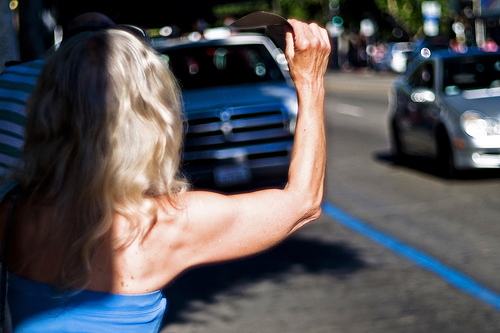

In [229]:
try_image = test_img[0]

NXS = predict_captions(try_image)
BS3 = beam_search_predictions(try_image, beam_index=3)
BS5 = beam_search_predictions(try_image, beam_index=5)
BS7 = beam_search_predictions(try_image, beam_index=7)
REF = [test_d[try_image][i].split() for i in range(5)]

chencherry = nltk.translate.bleu_score.SmoothingFunction()
NXS_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, NXS.split(), smoothing_function=chencherry.method4) 
BS3_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, BS3.split(), smoothing_function=chencherry.method4)    
BS5_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, BS5.split(), smoothing_function=chencherry.method4)    
BS7_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, BS7.split(), smoothing_function=chencherry.method4)    

for i in range(5):
    print ('True captions {}:'.format(i+1), test_d[try_image][i]) 
print ('Normal Max search, BLEU={}:'.format(round(NXS_BLEU, 2)), NXS) 
print ('Beam Search, k=3, BLEU={}:'.format(round(BS3_BLEU, 2)), BS3)
print ('Beam Search, k=5, BLEU={}:'.format(round(BS5_BLEU, 2)), BS5)
print ('Beam Search, k=7, BLEU={}:'.format(round(BS7_BLEU, 2)), BS7)
Image.open(try_image)

True captions 1: A baby in a white garment holds a flag with crescent moon and star .
True captions 2: A baby is holding a small black flag with a moon and a star on it .
True captions 3: A baby wearing a white gown waves a Muslim flag .
True captions 4: A little toddler dressed in white is smiling while a lady helps him wave a flag .
True captions 5: Baby in white outfit holding black and white flag .
Normal Max search, BLEU=0.22: A young boy wearing blue pants holding a baby at holding holding hands for a black and blue colored dog .
Beam Search, k=3, BLEU=0.3: A little boy holding a sign , with a crowd behind him .
Beam Search, k=5, BLEU=0.19: A little boy holding up a rope .
Beam Search, k=7, BLEU=0.19: A little boy holding up a rope .


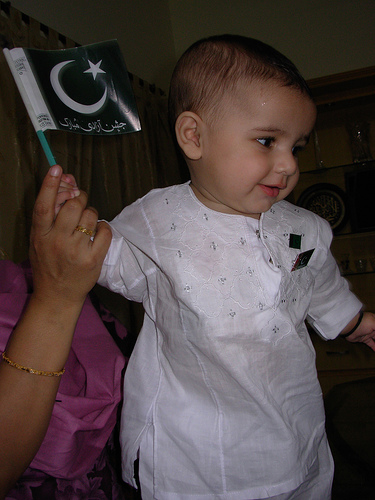

In [230]:
try_image2 = test_img[7]

NXS = predict_captions(try_image2)
BS3 = beam_search_predictions(try_image2, beam_index=3)
BS5 = beam_search_predictions(try_image2, beam_index=5)
BS7 = beam_search_predictions(try_image2, beam_index=7)
REF = [test_d[try_image2][i].split() for i in range(5)]

chencherry = nltk.translate.bleu_score.SmoothingFunction()
NXS_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, NXS.split(), smoothing_function=chencherry.method4) 
BS3_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, BS3.split(), smoothing_function=chencherry.method4)    
BS5_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, BS5.split(), smoothing_function=chencherry.method4)    
BS7_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, BS7.split(), smoothing_function=chencherry.method4)    

for i in range(5):
    print ('True captions {}:'.format(i+1), test_d[try_image2][i]) 
print ('Normal Max search, BLEU={}:'.format(round(NXS_BLEU, 2)), NXS) 
print ('Beam Search, k=3, BLEU={}:'.format(round(BS3_BLEU, 2)), BS3)
print ('Beam Search, k=5, BLEU={}:'.format(round(BS5_BLEU, 2)), BS5)
print ('Beam Search, k=7, BLEU={}:'.format(round(BS7_BLEU, 2)), BS7)
Image.open(try_image2)

True captions 1: A group of men in period clothing are standing in front of a hut .
True captions 2: A group of people dressed as pirates .
True captions 3: The people are in older looking attire .
True captions 4: The people in white and maroon clothes are in a wooden building .
True captions 5: The seven men are gathered .
Normal Max search, BLEU=0.17: Several girls are playing outside next to a wooden fence .
Beam Search, k=3, BLEU=0.2: Three girls are climbing on an amusement park ride
Beam Search, k=5, BLEU=0.2: Four girls are climbing on an amusement park ride
Beam Search, k=7, BLEU=0.2: Three girls stand on an amusement park ride .


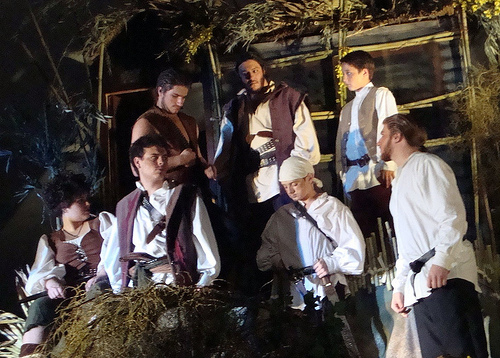

In [231]:
try_image3 = test_img[851]

NXS = predict_captions(try_image3)
BS3 = beam_search_predictions(try_image3, beam_index=3)
BS5 = beam_search_predictions(try_image3, beam_index=5)
BS7 = beam_search_predictions(try_image3, beam_index=7)
REF = [test_d[try_image3][i].split() for i in range(5)]

chencherry = nltk.translate.bleu_score.SmoothingFunction()
NXS_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, NXS.split(), smoothing_function=chencherry.method4) 
BS3_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, BS3.split(), smoothing_function=chencherry.method4)    
BS5_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, BS5.split(), smoothing_function=chencherry.method4)    
BS7_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, BS7.split(), smoothing_function=chencherry.method4)    

for i in range(5):
    print ('True captions {}:'.format(i+1), test_d[try_image3][i]) 
print ('Normal Max search, BLEU={}:'.format(round(NXS_BLEU, 2)), NXS) 
print ('Beam Search, k=3, BLEU={}:'.format(round(BS3_BLEU, 2)), BS3)
print ('Beam Search, k=5, BLEU={}:'.format(round(BS5_BLEU, 2)), BS5)
print ('Beam Search, k=7, BLEU={}:'.format(round(BS7_BLEU, 2)), BS7)
Image.open(try_image3)

True captions 1: A basset hound is leashed to the rearview mirror of a yellow and white vehicle
True captions 2: a black and white dog tied to a yellow and white van
True captions 3: A dog , lying down , tethered to the side mirror of a yellow VW bus .
True captions 4: a dog with black , white , and brown coloring is leashed up to a mirror
True captions 5: The black and white dog is tethered next to a yellow car .
Normal Max search, BLEU=0.2: A small child stands outside surrounded by buildings and one of white car .
Beam Search, k=3, BLEU=0.2: A small child dressed as a pirate stands up to face at the camera .
Beam Search, k=5, BLEU=0.2: A small child dressed as a pirate stands up to face at the camera .
Beam Search, k=7, BLEU=0.2: A small child dressed as a pirate stands up to face at the camera .


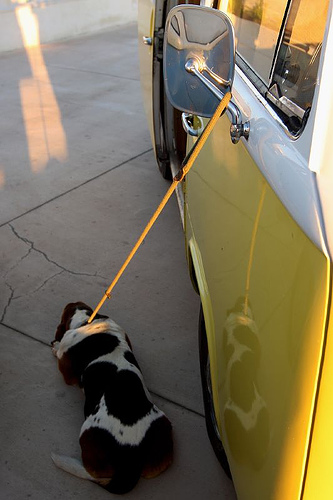

In [232]:
try_image4 = test_img[84]

NXS = predict_captions(try_image4)
BS3 = beam_search_predictions(try_image4, beam_index=3)
BS5 = beam_search_predictions(try_image4, beam_index=5)
BS7 = beam_search_predictions(try_image4, beam_index=7)
REF = [test_d[try_image4][i].split() for i in range(5)]

chencherry = nltk.translate.bleu_score.SmoothingFunction()
NXS_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, NXS.split(), smoothing_function=chencherry.method4) 
BS3_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, BS3.split(), smoothing_function=chencherry.method4)    
BS5_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, BS5.split(), smoothing_function=chencherry.method4)    
BS7_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, BS7.split(), smoothing_function=chencherry.method4)    

for i in range(5):
    print ('True captions {}:'.format(i+1), test_d[try_image4][i]) 
print ('Normal Max search, BLEU={}:'.format(round(NXS_BLEU, 2)), NXS) 
print ('Beam Search, k=3, BLEU={}:'.format(round(BS3_BLEU, 2)), BS3)
print ('Beam Search, k=5, BLEU={}:'.format(round(BS5_BLEU, 2)), BS5)
print ('Beam Search, k=7, BLEU={}:'.format(round(BS7_BLEU, 2)), BS7)
Image.open(try_image4)

True captions 1: A cop stands in front of a car on a busy street .
True captions 2: A man walks in the city .
True captions 3: An officer stands next to a car on a city street .
True captions 4: A policeman stands in front of an SUV .
True captions 5: A police officer is lighting a cigarette .
Normal Max search, BLEU=0.25: A group of people are walking along a rocky road .
Beam Search, k=3, BLEU=0.25: A group of people are walking along a rocky road .
Beam Search, k=5, BLEU=0.29: A group of people sit in chairs near a body of water .
Beam Search, k=7, BLEU=0.28: A group of people walk along a rocky road .


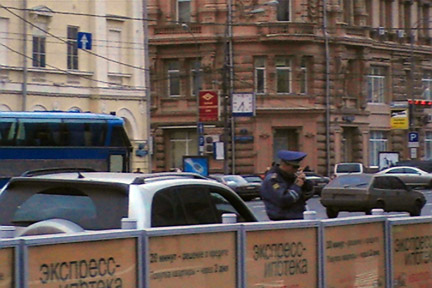

In [233]:
try_image5 = test_img[467]

NXS = predict_captions(try_image5)
BS3 = beam_search_predictions(try_image5, beam_index=3)
BS5 = beam_search_predictions(try_image5, beam_index=5)
BS7 = beam_search_predictions(try_image5, beam_index=7)
REF = [test_d[try_image5][i].split() for i in range(5)]

chencherry = nltk.translate.bleu_score.SmoothingFunction()
NXS_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, NXS.split(), smoothing_function=chencherry.method4) 
BS3_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, BS3.split(), smoothing_function=chencherry.method4)    
BS5_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, BS5.split(), smoothing_function=chencherry.method4)    
BS7_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, BS7.split(), smoothing_function=chencherry.method4)    

for i in range(5):
    print ('True captions {}:'.format(i+1), test_d[try_image5][i]) 
print ('Normal Max search, BLEU={}:'.format(round(NXS_BLEU, 2)), NXS) 
print ('Beam Search, k=3, BLEU={}:'.format(round(BS3_BLEU, 2)), BS3)
print ('Beam Search, k=5, BLEU={}:'.format(round(BS5_BLEU, 2)), BS5)
print ('Beam Search, k=7, BLEU={}:'.format(round(BS7_BLEU, 2)), BS7)
Image.open(try_image5)

True captions 1: A dog on two legs with its mouth opened toward a blue ball in the air .
True captions 2: A white dog catching a blue ball
True captions 3: A white dog jumps to catch a blue ball in a living room .
True captions 4: The dog is jumping in the air to catch a ball .
True captions 5: Two dogs in a family room are playing , one is catching a ball in its mouth .
Normal Max search, BLEU=0.29: The small dog jumps to catch a Frisbee while looking away from it .
Beam Search, k=3, BLEU=0.2: The white dog stands on top of an outdoor area with his back to the camera .
Beam Search, k=5, BLEU=0.23: One dog jumps to catch an orange Frisbee at night .
Beam Search, k=7, BLEU=0.26: There is a brown and white dog jumping to catch an obstacle course .


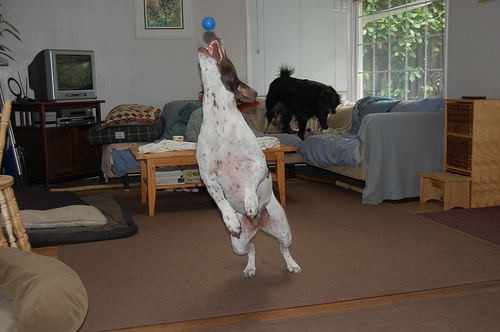

In [234]:
try_image6 = test_img[54]

NXS = predict_captions(try_image6)
BS3 = beam_search_predictions(try_image6, beam_index=3)
BS5 = beam_search_predictions(try_image6, beam_index=5)
BS7 = beam_search_predictions(try_image6, beam_index=7)
REF = [test_d[try_image6][i].split() for i in range(5)]

chencherry = nltk.translate.bleu_score.SmoothingFunction()
NXS_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, NXS.split(), smoothing_function=chencherry.method4) 
BS3_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, BS3.split(), smoothing_function=chencherry.method4)    
BS5_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, BS5.split(), smoothing_function=chencherry.method4)    
BS7_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, BS7.split(), smoothing_function=chencherry.method4)    

for i in range(5):
    print ('True captions {}:'.format(i+1), test_d[try_image6][i]) 
print ('Normal Max search, BLEU={}:'.format(round(NXS_BLEU, 2)), NXS) 
print ('Beam Search, k=3, BLEU={}:'.format(round(BS3_BLEU, 2)), BS3)
print ('Beam Search, k=5, BLEU={}:'.format(round(BS5_BLEU, 2)), BS5)
print ('Beam Search, k=7, BLEU={}:'.format(round(BS7_BLEU, 2)), BS7)
Image.open(try_image6)

True captions 1: A man on the beach is taking a picture of another man .
True captions 2: A man posing for his photo on a rocky beach .
True captions 3: A man takes a picture of another man at the beach .
True captions 4: Man filiming a man with sunglasses at the beach .
True captions 5: Two men are standing on a rocky shore , while one photographs the other .
Normal Max search, BLEU=0.2: Four boys are playing together on sand .
Beam Search, k=3, BLEU=0.23: Three boys playing with surfboard in the sand .
Beam Search, k=5, BLEU=0.23: Three boys playing with surfboard in the sand .
Beam Search, k=7, BLEU=0.29: A group of kids are playing together on sand .


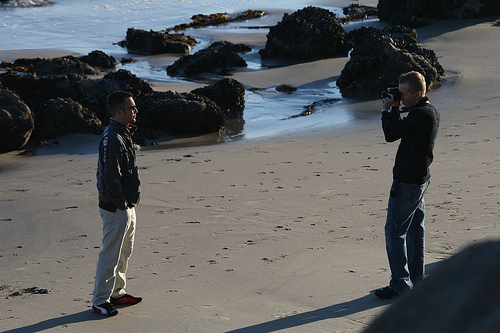

In [235]:
try_image7 = test_img[127]

NXS = predict_captions(try_image7)
BS3 = beam_search_predictions(try_image7, beam_index=3)
BS5 = beam_search_predictions(try_image7, beam_index=5)
BS7 = beam_search_predictions(try_image7, beam_index=7)
REF = [test_d[try_image7][i].split() for i in range(5)]

chencherry = nltk.translate.bleu_score.SmoothingFunction()
NXS_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, NXS.split(), smoothing_function=chencherry.method4) 
BS3_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, BS3.split(), smoothing_function=chencherry.method4)    
BS5_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, BS5.split(), smoothing_function=chencherry.method4)    
BS7_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, BS7.split(), smoothing_function=chencherry.method4)    

for i in range(5):
    print ('True captions {}:'.format(i+1), test_d[try_image7][i]) 
print ('Normal Max search, BLEU={}:'.format(round(NXS_BLEU, 2)), NXS) 
print ('Beam Search, k=3, BLEU={}:'.format(round(BS3_BLEU, 2)), BS3)
print ('Beam Search, k=5, BLEU={}:'.format(round(BS5_BLEU, 2)), BS5)
print ('Beam Search, k=7, BLEU={}:'.format(round(BS7_BLEU, 2)), BS7)
Image.open(try_image7)

True captions 1: A group of people in a boat , white water rafting .
True captions 2: A group of seven people are rafting in the rapids in a green boat .
True captions 3: Rafting boat on river .
True captions 4: seven people are riding a green raft in a white water river .
True captions 5: Seven rafters are paddling and riding the rapids in a green raft .
Normal Max search, BLEU=0.33: A group of people are riding on a rock that .
Beam Search, k=3, BLEU=0.25: A group of people wearing yellow are riding on a snowy mountain .
Beam Search, k=5, BLEU=0.25: A group of people wearing yellow are riding on a snowy mountain .
Beam Search, k=7, BLEU=0.26: A group of people dressed in yellow are riding on a wave .


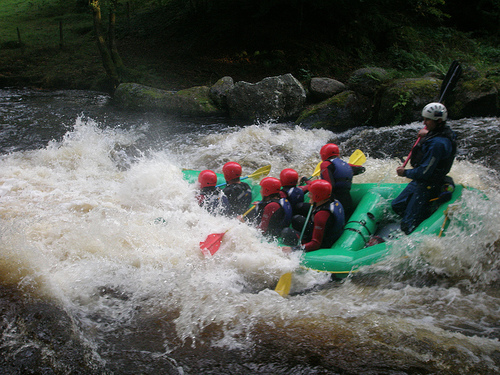

In [236]:
try_image8 = test_img[63]

NXS = predict_captions(try_image8)
BS3 = beam_search_predictions(try_image8, beam_index=3)
BS5 = beam_search_predictions(try_image8, beam_index=5)
BS7 = beam_search_predictions(try_image8, beam_index=7)
REF = [test_d[try_image8][i].split() for i in range(5)]

chencherry = nltk.translate.bleu_score.SmoothingFunction()
NXS_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, NXS.split(), smoothing_function=chencherry.method4) 
BS3_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, BS3.split(), smoothing_function=chencherry.method4)    
BS5_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, BS5.split(), smoothing_function=chencherry.method4)    
BS7_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, BS7.split(), smoothing_function=chencherry.method4)    

for i in range(5):
    print ('True captions {}:'.format(i+1), test_d[try_image8][i]) 
print ('Normal Max search, BLEU={}:'.format(round(NXS_BLEU, 2)), NXS) 
print ('Beam Search, k=3, BLEU={}:'.format(round(BS3_BLEU, 2)), BS3)
print ('Beam Search, k=5, BLEU={}:'.format(round(BS5_BLEU, 2)), BS5)
print ('Beam Search, k=7, BLEU={}:'.format(round(BS7_BLEU, 2)), BS7)
Image.open(try_image8)

True captions 1: A man in blue jumping a dirt bike .
True captions 2: A man on a dirt bike , airborne .
True captions 3: A man on a motorcycle is jumping over a dirt hill in front of spectators .
True captions 4: A motocross rider wearing a blue uniform flies through the air .
True captions 5: A person in blue on a bike in midair .
Normal Max search, BLEU=0.26: A person wearing a green jacket and backpack riding a red bicycle down a dirt trail .
Beam Search, k=3, BLEU=0.27: A group of men are riding bikes down a city street .
Beam Search, k=5, BLEU=0.22: An old mountain biker does a trick in midair .
Beam Search, k=7, BLEU=0.22: An old mountain biker does a trick in midair .


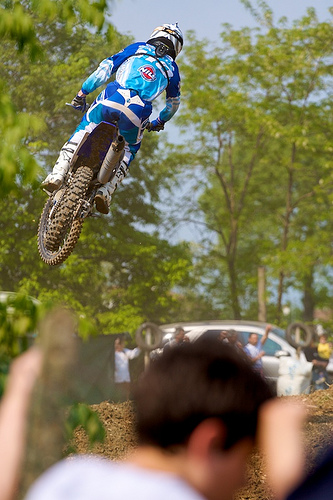

In [237]:
try_image9 = test_img[793]

NXS = predict_captions(try_image9)
BS3 = beam_search_predictions(try_image9, beam_index=3)
BS5 = beam_search_predictions(try_image9, beam_index=5)
BS7 = beam_search_predictions(try_image9, beam_index=7)
REF = [test_d[try_image9][i].split() for i in range(5)]

chencherry = nltk.translate.bleu_score.SmoothingFunction()
NXS_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, NXS.split(), smoothing_function=chencherry.method4) 
BS3_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, BS3.split(), smoothing_function=chencherry.method4)    
BS5_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, BS5.split(), smoothing_function=chencherry.method4)    
BS7_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, BS7.split(), smoothing_function=chencherry.method4)    

for i in range(5):
    print ('True captions {}:'.format(i+1), test_d[try_image9][i]) 
print ('Normal Max search, BLEU={}:'.format(round(NXS_BLEU, 2)), NXS) 
print ('Beam Search, k=3, BLEU={}:'.format(round(BS3_BLEU, 2)), BS3)
print ('Beam Search, k=5, BLEU={}:'.format(round(BS5_BLEU, 2)), BS5)
print ('Beam Search, k=7, BLEU={}:'.format(round(BS7_BLEU, 2)), BS7)
Image.open(try_image9)

True captions 1: a froup of sled dogs pulling a man wearing an orange vest .
True captions 2: A three dog sled team pulls an unusual tricycle sled .
True captions 3: Several dogs carry a man with a helmet through snow .
True captions 4: The dogs are pulling a man on a type of bike , through the snow .
True captions 5: Three dogs pulling a man on a bicycle through the snow .
Normal Max search, BLEU=0.22: Three people are in the snow and one has a red dogs .
Beam Search, k=3, BLEU=0.21: A group of people are in the snow .
Beam Search, k=5, BLEU=0.19: a group of people running through the snow with trees in the background
Beam Search, k=7, BLEU=0.19: a group of people running through the snow with trees in the background


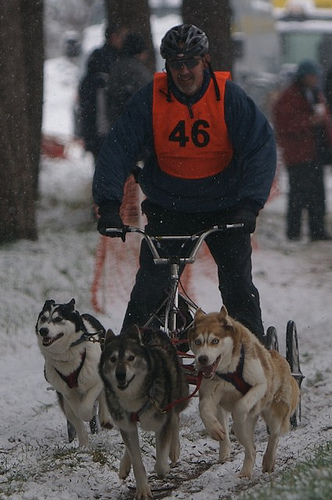

In [238]:
try_image10 = test_img[209]

NXS = predict_captions(try_image10)
BS3 = beam_search_predictions(try_image10, beam_index=3)
BS5 = beam_search_predictions(try_image10, beam_index=5)
BS7 = beam_search_predictions(try_image10, beam_index=7)
REF = [test_d[try_image10][i].split() for i in range(5)]

chencherry = nltk.translate.bleu_score.SmoothingFunction()
NXS_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, NXS.split(), smoothing_function=chencherry.method4) 
BS3_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, BS3.split(), smoothing_function=chencherry.method4)    
BS5_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, BS5.split(), smoothing_function=chencherry.method4)    
BS7_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, BS7.split(), smoothing_function=chencherry.method4)    

for i in range(5):
    print ('True captions {}:'.format(i+1), test_d[try_image10][i]) 
print ('Normal Max search, BLEU={}:'.format(round(NXS_BLEU, 2)), NXS) 
print ('Beam Search, k=3, BLEU={}:'.format(round(BS3_BLEU, 2)), BS3)
print ('Beam Search, k=5, BLEU={}:'.format(round(BS5_BLEU, 2)), BS5)
print ('Beam Search, k=7, BLEU={}:'.format(round(BS7_BLEU, 2)), BS7)
Image.open(try_image10)

True captions 1: A woman playing an acoustic guitar with a microphone
True captions 2: A woman singing and playing the acoustic guitar onstage .
True captions 3: A woman sings into a microphone while playing guitar .
True captions 4: A young brown haired woman plays her guitar and sings into a microphone .
True captions 5: A young woman plays guitar and sings on a stage .
Normal Max search, BLEU=0.24: A man plays guitar next to a hurdle .
Beam Search, k=3, BLEU=0.27: A little boy plays with a guitar .
Beam Search, k=5, BLEU=0.27: A little boy plays guitar next to a guitar .
Beam Search, k=7, BLEU=0.27: There is a little boy playing with a guitar .


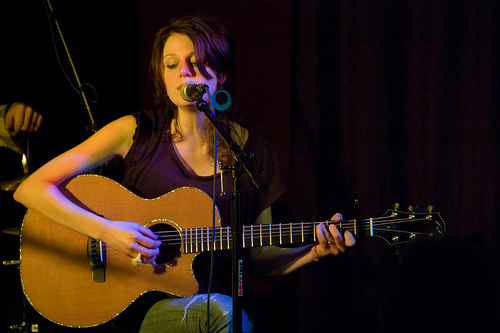

In [239]:
try_image11 = test_img[568]

NXS = predict_captions(try_image11)
BS3 = beam_search_predictions(try_image11, beam_index=3)
BS5 = beam_search_predictions(try_image11, beam_index=5)
BS7 = beam_search_predictions(try_image11, beam_index=7)
REF = [test_d[try_image11][i].split() for i in range(5)]

chencherry = nltk.translate.bleu_score.SmoothingFunction()
NXS_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, NXS.split(), smoothing_function=chencherry.method4) 
BS3_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, BS3.split(), smoothing_function=chencherry.method4)    
BS5_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, BS5.split(), smoothing_function=chencherry.method4)    
BS7_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, BS7.split(), smoothing_function=chencherry.method4)    

for i in range(5):
    print ('True captions {}:'.format(i+1), test_d[try_image11][i]) 
print ('Normal Max search, BLEU={}:'.format(round(NXS_BLEU, 2)), NXS) 
print ('Beam Search, k=3, BLEU={}:'.format(round(BS3_BLEU, 2)), BS3)
print ('Beam Search, k=5, BLEU={}:'.format(round(BS5_BLEU, 2)), BS5)
print ('Beam Search, k=7, BLEU={}:'.format(round(BS7_BLEU, 2)), BS7)
Image.open(try_image11)

True captions 1: One child reaches up for something while another stands beside him .
True captions 2: One child with a colourful toy and another child reaching up .
True captions 3: Two babies in sweaters playing with a toy .
True captions 4: Two children have expressions of happiness as they reach for something out of sight .
True captions 5: Two kids playing on a street
Normal Max search, BLEU=0.23: Young girl smiling in park , smiling for camera
Beam Search, k=3, BLEU=0.26: Young girl plays with two people in the face .
Beam Search, k=5, BLEU=0.26: Young girl plays with two people in the tree .
Beam Search, k=7, BLEU=0.25: There is a young girl taking a picture next to a group of people .


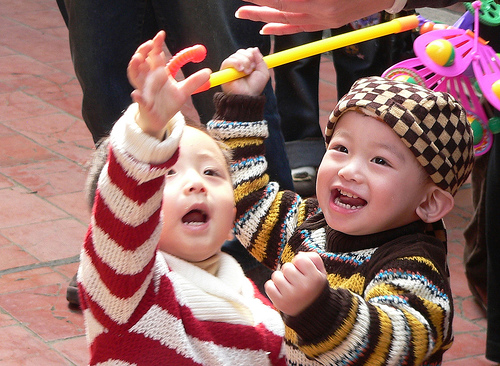

In [240]:
try_image12 = test_img[int(np.random.randint(0, 1000, size=1))]

NXS = predict_captions(try_image12)
BS3 = beam_search_predictions(try_image12, beam_index=3)
BS5 = beam_search_predictions(try_image12, beam_index=5)
BS7 = beam_search_predictions(try_image12, beam_index=7)
REF = [test_d[try_image12][i].split() for i in range(5)]

chencherry = nltk.translate.bleu_score.SmoothingFunction()
NXS_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, NXS.split(), smoothing_function=chencherry.method4) 
BS3_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, BS3.split(), smoothing_function=chencherry.method4)    
BS5_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, BS5.split(), smoothing_function=chencherry.method4)    
BS7_BLEU = nltk.translate.bleu_score.sentence_bleu(REF, BS7.split(), smoothing_function=chencherry.method4)    

for i in range(5):
    print ('True captions {}:'.format(i+1), test_d[try_image12][i]) 
print ('Normal Max search, BLEU={}:'.format(round(NXS_BLEU, 2)), NXS) 
print ('Beam Search, k=3, BLEU={}:'.format(round(BS3_BLEU, 2)), BS3)
print ('Beam Search, k=5, BLEU={}:'.format(round(BS5_BLEU, 2)), BS5)
print ('Beam Search, k=7, BLEU={}:'.format(round(BS7_BLEU, 2)), BS7)
Image.open(try_image12)

# Summary

The results are not as good as expected. One of the possible reason is that we used Google's pre-trained Word2Vec and fixed the weights for model training. It may not be suitable to use Google's Word2Vec due to the contextual different between image captions and news.